In [2]:
import importlib
from SpLSI import generate_topic_model as gen_model
from SpLSI import utils 
from SpLSI import splsi_
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain  
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from types import SimpleNamespace
import time
import statistics
import contextlib
import random
import os
import sys
import warnings
import community as community_louvain  

/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri

In [4]:
importlib.reload(gen_model)
importlib.reload(splsi_)
importlib.reload(utils)

<module 'SpLSI.utils' from '/Users/zhangzeyu/Downloads/research/SpLSI/SpLSI/utils.py'>

In [4]:
def simulation(k=4, iteration=10, sct_transform=True, maxiter=50, N=1000, noise=False):
    acc_spectral = []
    time_spectral = []
    l2_error_spectral = []
    acc_bayes = []
    time_bayes = []
    acc_spatial = []
    time_spatial = []
    l2_error_spatial = []
    l2_error_pca = []
    acc_pca = []

    i = 0
    while i < iteration:
        try:
            coords_df = gen_model.generate_graph(100, N, 30, k, 0.05)
            W = gen_model.generate_W_strong(coords_df, 100, N, 30, k, 0.05) 
            L = np.diag(np.random.rand(min(W.shape)))
            V, _ = np.linalg.qr(np.random.randn(30, W.shape[0])) # fix p = 30
            X = W.T @ L @ V.T

            if noise:
                X = X + np.random.normal(0, 0.02, X.shape)
                
            X = utils.euclidean_proj_simplex(X, s=1)
            X = utils.multinomial_from_rows(X,n=100)
            
            pandas2ri.activate()
            numpy2ri.activate()
            robjects.globalenv['k'] = k
            ### SpatialPCA
            counts = X.T  
            location = coords_df.iloc[:, :2].to_numpy()  

            counts_r = numpy2ri.py2rpy(counts)
            location_r = numpy2ri.py2rpy(location)
            robjects.globalenv['counts_r'] = counts_r
            robjects.globalenv['location_r'] = location_r

            robjects.r('rownames(counts_r) <- 1:nrow(counts_r)')
            robjects.r('colnames(counts_r) <- 1:ncol(counts_r)')
            robjects.r('rownames(location_r) <- 1:nrow(location_r)')

            start_time_3 = time.time()
            robjects.r('''
            library(SpatialPCA)

            ST <- CreateSpatialPCAObject(counts = counts_r,
                location = location_r,
                project = "SpatialPCA",
                gene.type = "spatial",
                sparkversion = "spark",
                min.loctions = 2,
                min.features = 5
            )

            ST <- SpatialPCA_buildKernel(
                ST,
                kerneltype = "gaussian",
                bandwidthtype = "SJ"
            )

            ST <- SpatialPCA_EstimateLoading(
                ST,
                fast = FALSE,
                SpatialPCnum = k
            )

            ST <- SpatialPCA_SpatialPCs(
                ST,
                fast = FALSE
            )
            ''')
            end_time_3 = time.time()
            running_time_3 = end_time_3 - start_time_3
            time_spatial.append(running_time_3)

            SpatialPC = robjects.r('ST@SpatialPCs')
            acc_spatial.append(utils.group_and_compare_spectral(SpatialPC.T, coords_df))
            l2_error_spatial.append(utils.get_l2_err(W, SpatialPC.T))

            if sct_transform:
                numpy2ri.activate()
                pandas2ri.activate()
                seurat = rpackages.importr('Seurat')

                r_X_T = numpy2ri.py2rpy(X.T)
                robjects.globalenv['counts_matrix'] = r_X_T

                robjects.r('''
                    library(Seurat)
                    seurat_obj <- CreateSeuratObject(counts = as.matrix(counts_matrix))
                    seurat_obj <- SCTransform(seurat_obj, verbose = FALSE)
                    normalized_matrix <- as.data.frame(GetAssayData(seurat_obj, layer = "data", assay = "SCT"))
                ''')

                normalized_df = pandas2ri.rpy2py(robjects.globalenv['normalized_matrix'])
                X_norm = normalized_df.to_numpy().T
                X_norm = X_norm - np.mean(X_norm, axis=0)
            else:
                pass

            ### SpatialSVD and Regular PCA
            weights, edge_df = gen_model.generate_weights_edge(coords_df, 4, 0.05)
            start_time_1 = time.time()
            model_hooi = splsi_.SpLSI_(lamb_start=0.001,maxiter=maxiter,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-06,normalize=True,L_inv_=True)
            model_hooi.fit(X_norm, k, edge_df, weights)
            end_time_1 = time.time()
            running_time_1 = end_time_1 - start_time_1

            U = model_hooi.U
            V_hat = model_hooi.V

            acc_spectral.append(utils.group_and_compare_spectral(U, coords_df))
            time_spectral.append(running_time_1)
            l2_error_spectral.append(utils.get_l2_err(W, U))
            
            U_svd, _, _ = svds(X_norm.astype(float), k=k)
            acc_pca.append(utils.group_and_compare_spectral(U_svd, coords_df))
            l2_error_pca.append(utils.get_l2_err(W, U_svd))

            ### BayesSpace
            SingleCellExperiment = rpackages.importr('SingleCellExperiment')
            BayesSpace = rpackages.importr('BayesSpace')

            coords_df_r = coords_df.iloc[:, :2]
            coords_df_r.columns = ['row', 'col']
            location_df_r = pandas2ri.py2rpy(coords_df_r)

            robjects.globalenv['counts_matrix'] = X.T 
            robjects.globalenv['location_df'] = location_df_r

            start_time_2 = time.time()
            robjects.r('''
            rownames(counts_matrix) <- 1:nrow(counts_matrix)
            colnames(counts_matrix) <- 1:ncol(counts_matrix)
            rownames(location_df) <- 1:ncol(counts_matrix)

            sce <- SingleCellExperiment(
            assays = list(counts = counts_matrix),
            colData = location_df
            )

            sce <- spatialPreprocess(sce, platform = "ST", 
                                    n.PCs = k, n.HVGs = 2000, log.normalize = TRUE)

            sce <- spatialCluster(sce, q = k, platform = "ST", d = k,
                                init.method = "mclust", model = "t", gamma = 2,
                                nrep = 10000, burn.in = 100, save.chain = TRUE)
            ''')
            end_time_2 = time.time()
            running_time_2 = end_time_2 - start_time_2
            time_bayes.append(running_time_2)

            clusters = robjects.r('sce$spatial.cluster')
            acc_bayes.append(utils.get_accuracy(clusters-1, coords_df))



            i+=1

        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            print("Retrying the current iteration...")
            continue  # Restart the same iteration

    return SimpleNamespace(acc_spectral=statistics.mean(acc_spectral), acc_spectral_list=acc_spectral,time_spectral=statistics.mean(time_spectral),l2_spectral=l2_error_spectral,
                           acc_pca=statistics.mean(acc_pca),l2_pca=l2_error_pca,
                           acc_bayes=statistics.mean(acc_bayes), time_bayes=statistics.mean(time_bayes),acc_bayes_list=acc_bayes,
                           acc_spatial=statistics.mean(acc_spatial),acc_spatial_list=acc_spatial, time_spatial=statistics.mean(time_spatial), l2_spatial=l2_error_spatial)

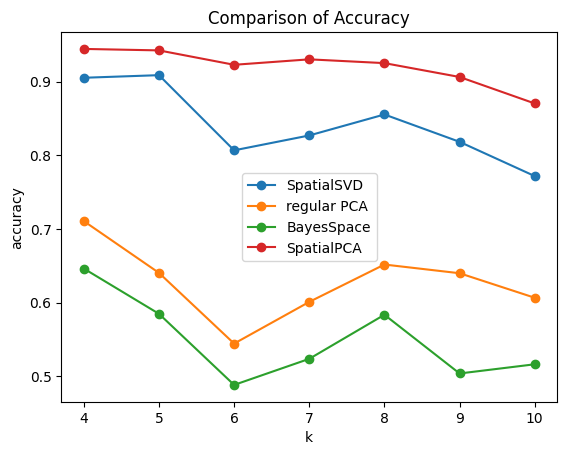

In [16]:
results = [result_4, result_5, result_6, result_7, result_8, result_9, result_10]

plt.plot(range(4, 11), [result.acc_spectral for result in results], marker='o', label='SpatialSVD')
plt.plot(range(4, 11), [result.acc_pca for result in results], marker='o', label='regular PCA')
plt.plot(range(4, 11), [result.acc_bayes for result in results], marker='o', label='BayesSpace')
plt.plot(range(4, 11), [result.acc_spatial for result in results], marker='o', label='SpatialPCA')

plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

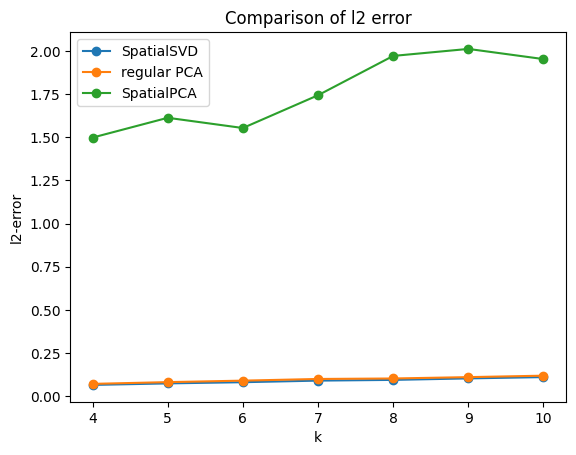

In [14]:
plt.plot(range(4, 11), [np.mean(result.l2_spectral) for result in results], marker='o', label='SpatialSVD')
plt.plot(range(4, 11), [np.mean(result.l2_pca )for result in results], marker='o', label='regular PCA')
plt.plot(range(4, 11), [np.mean(result.l2_spatial) for result in results], marker='o', label='SpatialPCA')

plt.xlabel('k')
plt.ylabel('l2-error')
plt.title('Comparison of l2 error')
plt.legend()
plt.show()

/var/folders/7n/m3fx8n9517d9ps5my79_4yv80000gn/T/ipykernel_30527/2557444409.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([result.acc_spectral_list for result in results], labels=range(4, 11))


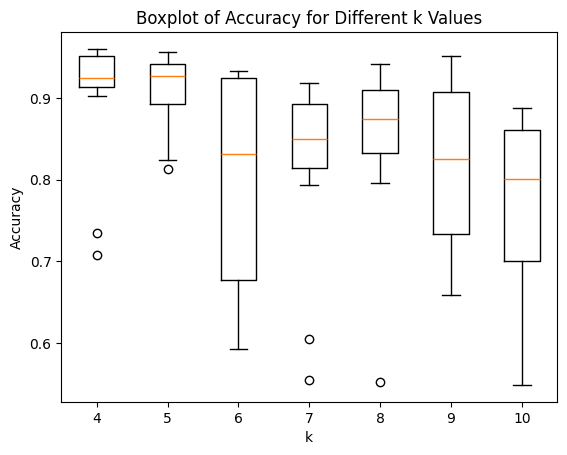

In [15]:
plt.boxplot([result.acc_spectral_list for result in results], labels=range(4, 11))
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Boxplot of Accuracy for Different k Values")
plt.show()

In [ ]:
result_4 = simulation(k=4, iteration=15, maxiter=30, N=1000)

In [ ]:
result_5 = simulation(k=5, iteration=15, maxiter=30, N=1000)

In [ ]:
result_6 = simulation(k=6, iteration=15, maxiter=30, N=1000)

In [ ]:
result_7 = simulation(k=7, iteration=15, maxiter=30, N=1000)

In [ ]:
result_8 = simulation(k=8, iteration=15, maxiter=30, N=1000)

In [ ]:
result_9 = simulation(k=9, iteration=15, maxiter=30, N=1000)

In [ ]:
result_10 = simulation(k=10, iteration=15, maxiter=30, N=1000)